# Full Photometry Pipeline

This tutorial demonstrates how to run the end--to--end photometry pipeline on
real JWST data included with *Mophongo*. We build templates from the F444W
mosaic and fit fluxes in the F770W image using spatially varying PSF
matching kernels.

## Detect sources in F444W

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits

data_dir = Path('../data')
field = data_dir / 'uds-test'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'


## Build PSF region map

/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


,geometry,psf_key_1,psf_key_2,psf_key
0,"POLYGON ((34.30361 -5.10681, 34.30431 -5.10875...",0,1,0
1,"POLYGON ((34.30556 -5.10681, 34.30583 -5.10736...",1,0,1
2,"POLYGON ((34.30361 -5.10681, 34.30472 -5.10681...",1,1,2
3,"POLYGON ((34.29764 -5.11472, 34.29764 -5.10681...",2,1,3
4,"POLYGON ((34.3025 -5.11042, 34.30361 -5.11292,...",3,1,4
5,"POLYGON ((34.30361 -5.11292, 34.30444 -5.11472...",4,1,5
6,"POLYGON ((34.30431 -5.10875, 34.30528 -5.11139...",5,1,6
7,"POLYGON ((34.30431 -5.11472, 34.30444 -5.11472...",6,1,7
8,"POLYGON ((34.30681 -5.11, 34.30806 -5.11333, 3...",7,0,8
9,"POLYGON ((34.30583 -5.11083, 34.30667 -5.11389...",7,1,9


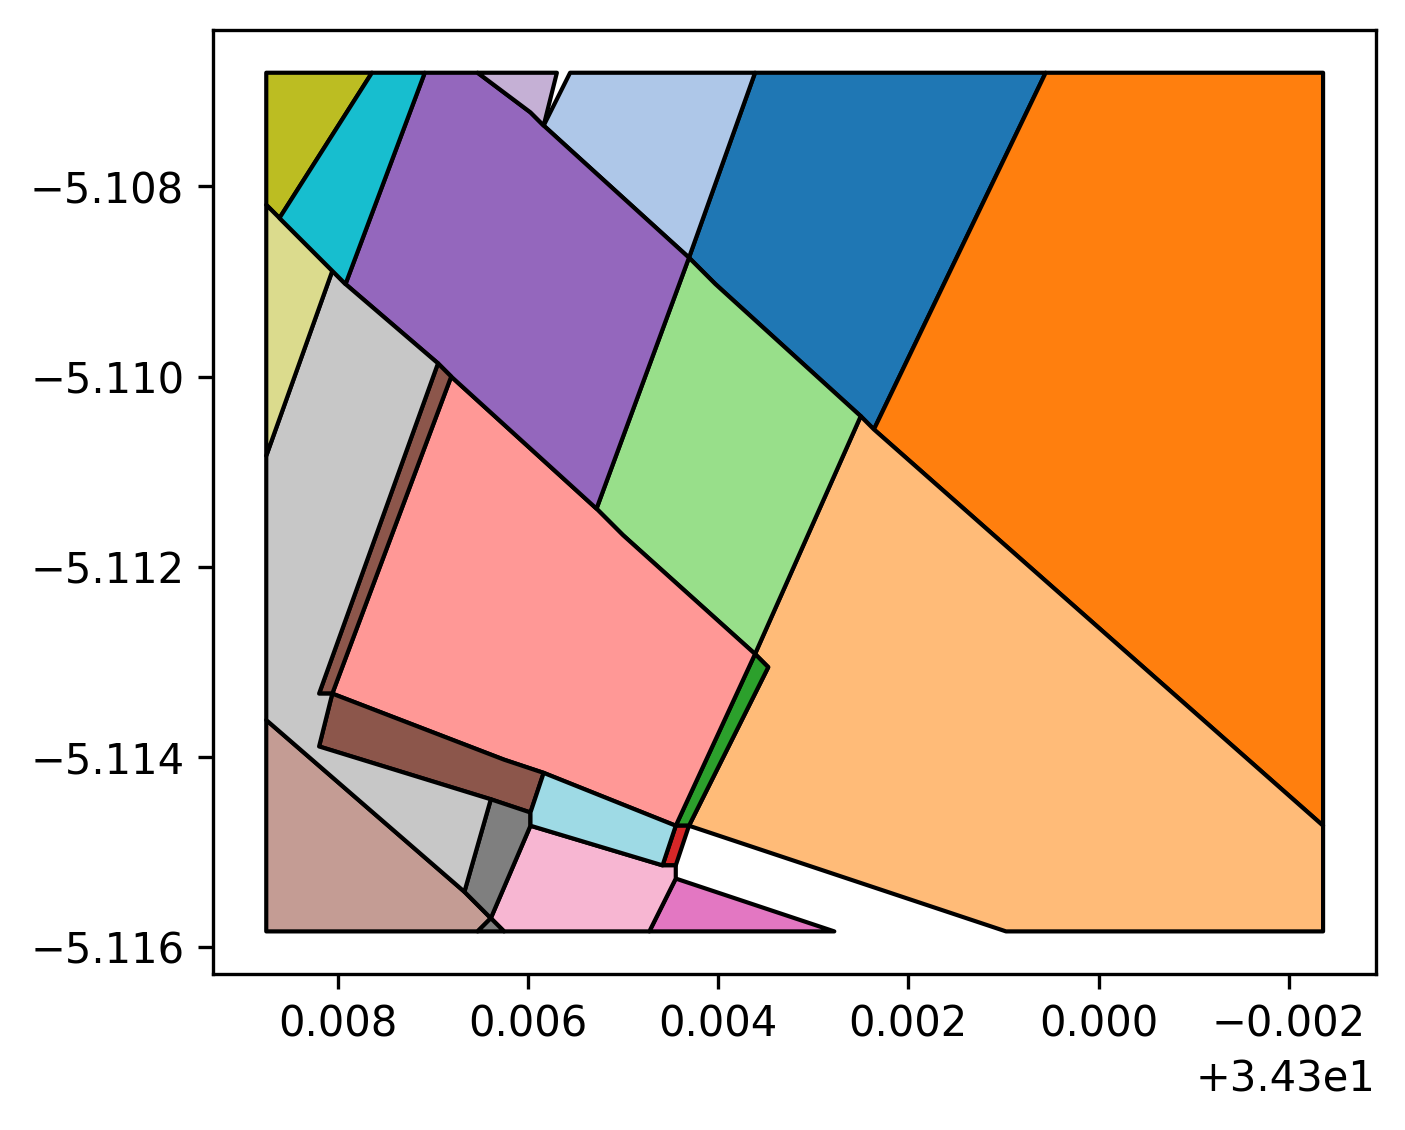

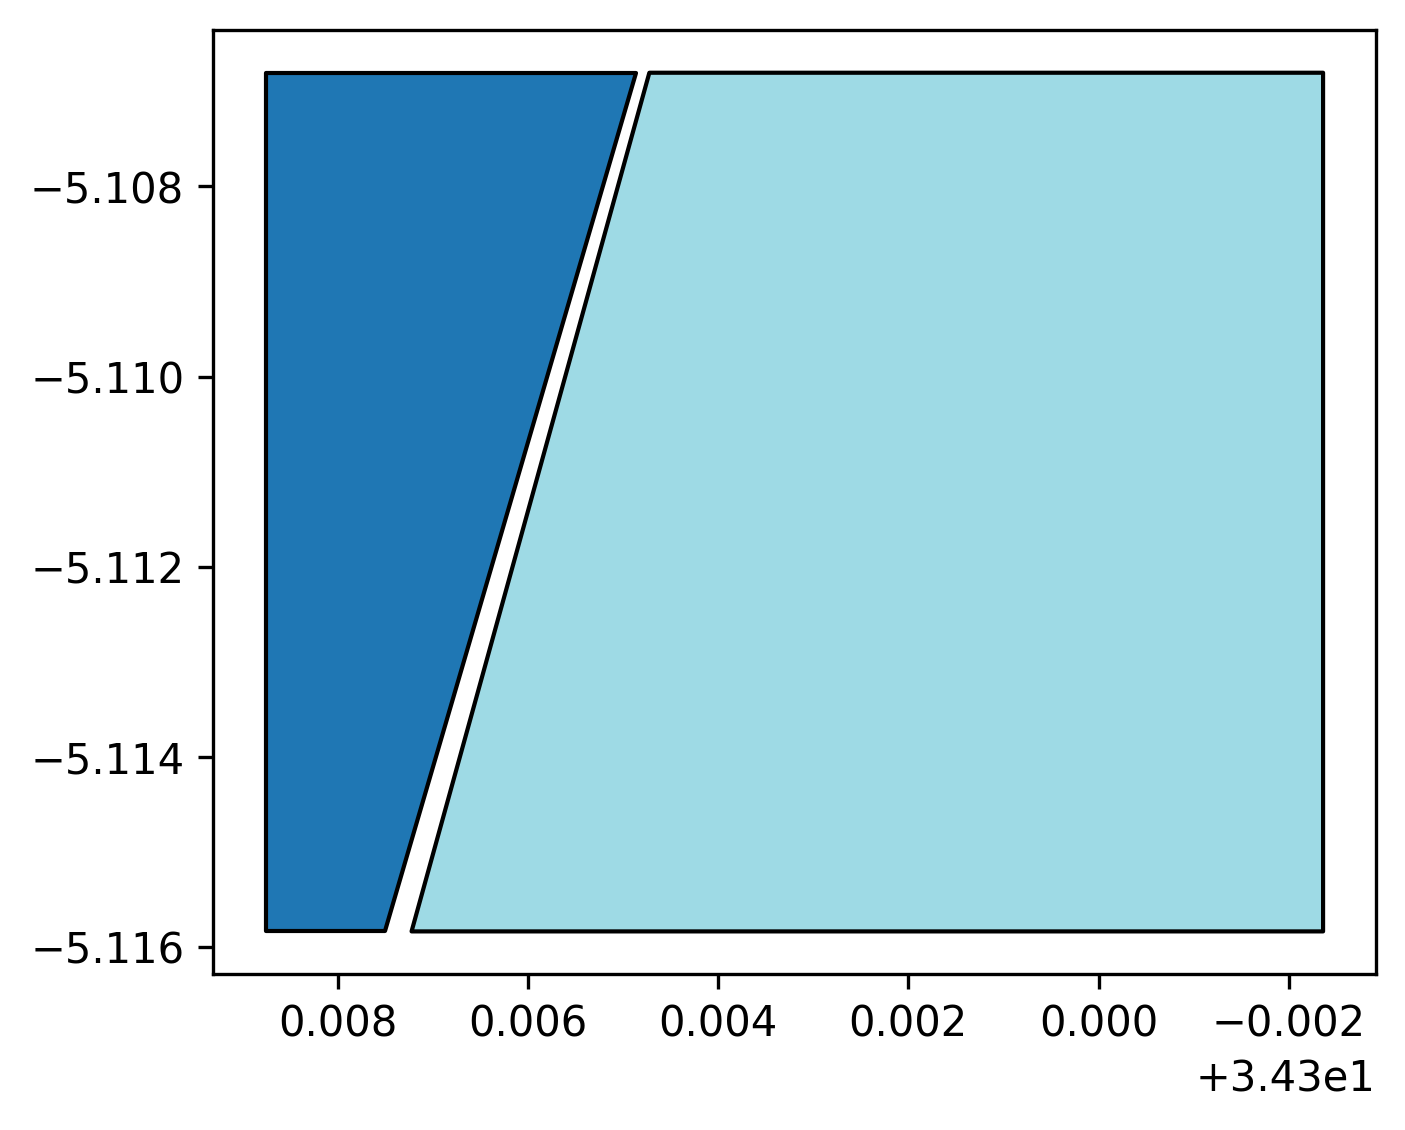

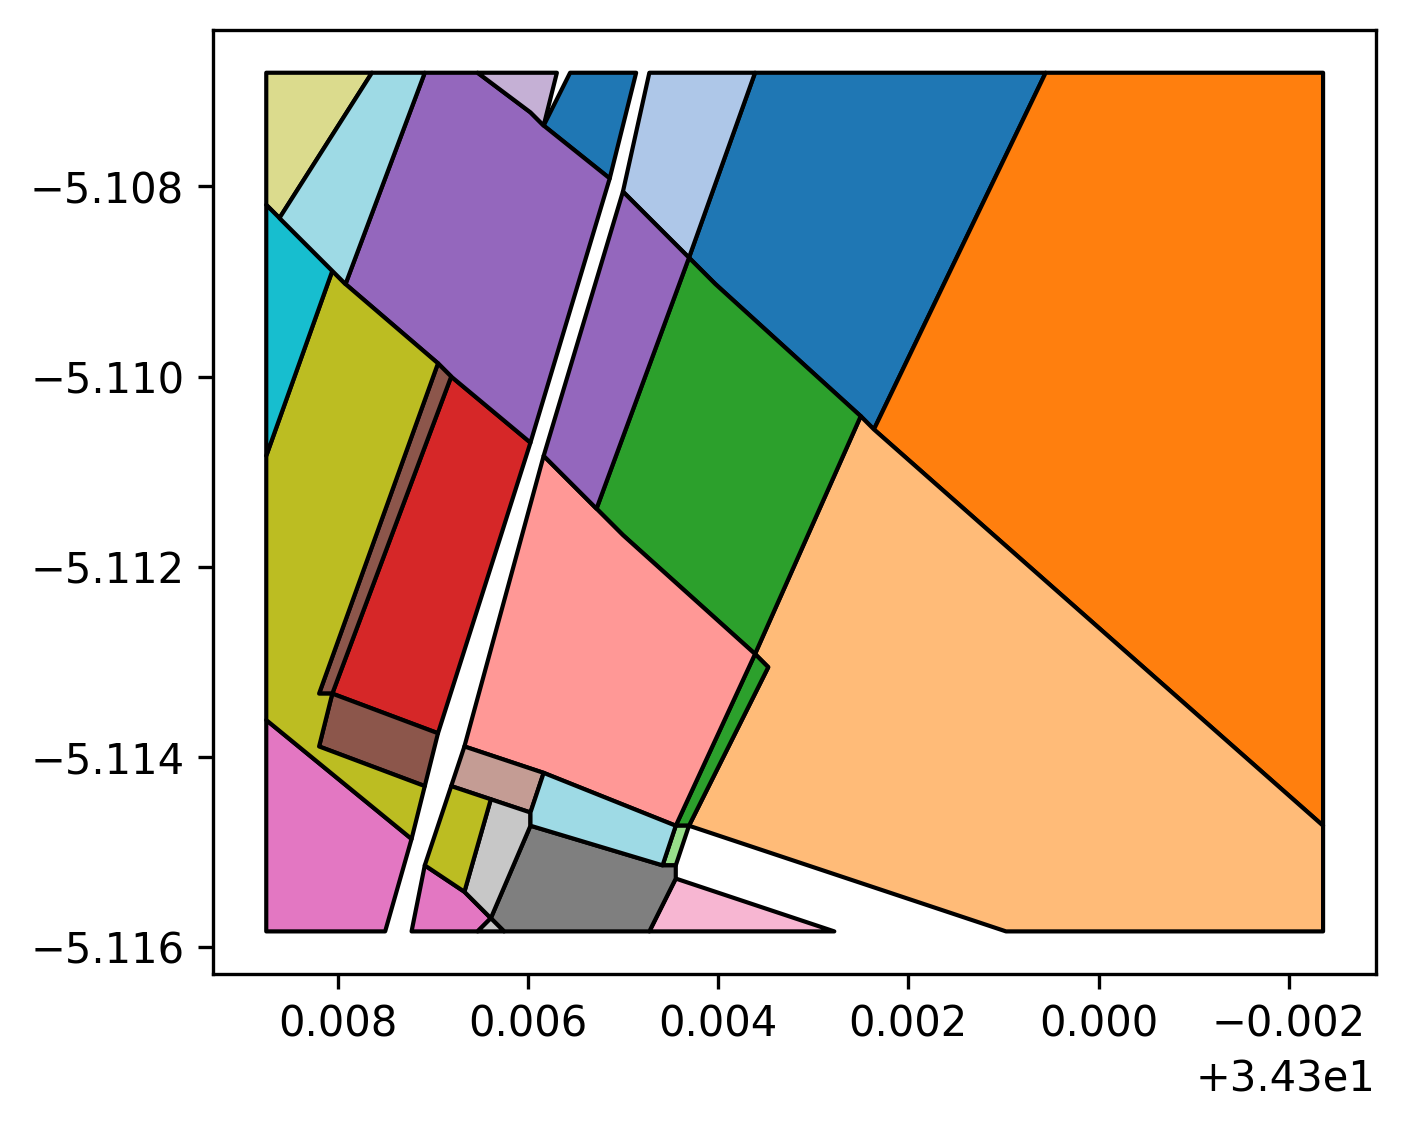

In [2]:
from mophongo.psf import DrizzlePSF
from mophongo.psf_map import PSFRegionMap

# also reads the associated _wcs.csv files
dpsf_444 = DrizzlePSF(driz_image=str(sci_444))
dpsf_770 = DrizzlePSF(driz_image=str(sci_444).replace('444', '770'))

# Keep only footprints overlapping the drizzled mosaic
prm_444 = PSFRegionMap.from_footprints(dpsf_444.footprint).overlay_with(dpsf_444.driz_footprint)
prm_770 = PSFRegionMap.from_footprints(dpsf_770.footprint).overlay_with(dpsf_444.driz_footprint)

# compute overlay regions unique to both PSFs
prm_kern = prm_444.overlay_with(prm_770)
prm_kern.name = '444 to 770 kernel'
prm_444.plot()
prm_770.plot()
prm_kern.plot()
prm_kern.regions

## Create PSF kernels

In [3]:
import mophongo.utils as utils

psf_dir = data_dir / 'PSF'
stpsf_444 = 'UDS_NRC.._F444W_OS4_GRID25'
stpsf_770 = 'UDS_MIRI_F770W_OS4_GRID9'
size = 201

# centroid positions of the regions 
pos = [np.squeeze(p.xy) for p in prm_kern.regions.geometry.centroid]

# load webb psfs
dpsf_444.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_444)
dpsf_770.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_770)

# drizzle at centroid positions
prm_444.psfs = dpsf_444.get_psf_radec(pos, size=size)    
prm_770.psfs = dpsf_770.get_psf_radec(pos, size=size)    

# match kernels
kernels = [utils.matching_kernel(psf_444, psf_770, recenter=True) for psf_444, psf_770 in zip(prm_444.psfs, prm_770.psfs)]

prm_kern.psfs = np.asarray(kernels)
prm_kern.to_file(data_dir / f'{field}-f444w_kernel_f770w.geojson') 

## Run photometry

In [5]:
from pathlib import Path
from astropy.io import fits
from mophongo.psf_map import PSFRegionMap
from mophongo.fit import FitConfig
from mophongo.astro_fit import GlobalAstroFitter
from mophongo.catalog import Catalog
from mophongo import pipeline

data_dir = Path('../data')
field = data_dir / 'uds-test'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'

prm_kern = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_kernel_f770w.geojson'))

# MIRI images
img_770 = fits.getdata(data_dir / f'{field}-f770w_sci.fits')
wht_770 = fits.getdata(data_dir / f'{field}-f770w_wht.fits')

# read in LW selected catalog
seg_LW = data_dir / f'{field}-LW_seg.fits'
cat444 = Catalog.from_fits(sci_444, wht_444, segmap=seg_LW, estimate_ivar=True)
cat770 = Catalog.from_fits(img_770, wht_770, segmap=seg_LW, estimate_ivar=True) 

# fitting photometry first image is template, 2nd and on the fitting images
niter = 0
config = FitConfig(fit_astrometry=False, astrom_basis_order=1, reg_astrom=1e-4, snr_thresh_astrom=10.0, fit_astrometry_niter=niter)
table, res, fit = pipeline.run([cat444.sci, cat770.sci], cat444.segmap.data,
                                weights=[cat444.ivar, cat770.ivar],
                                catalog=cat444.table,
                                kernels=[None, prm_kern],
                                wcs=[cat444.wcs]* 2,
                                config=config)
fits.writeto('residual'+str(niter)+'.fits',res[0],overwrite=True)
fits.writeto('model.fits',img_770-res[0],overwrite=True)

residual = []
for niter in (1,2,3):
    config = FitConfig(fit_astrometry=True, astrom_basis_order=1, reg_astrom=1e-4, snr_thresh_astrom=10.0, fit_astrometry_niter=niter)
    table, res, fit = pipeline.run([cat444.sci, cat770.sci], cat444.segmap.data,
                                    weights=[cat444.ivar, cat770.ivar],
                                    catalog=cat444.table,
                                    kernels=[None, prm_kern],
                                    wcs=[cat444.wcs]* 2,
                                    config=config)
    residual.append(res[0])
    table.write('photometry.cat', format='ascii.commented_header', overwrite=True)
    fits.writeto('residual'+str(niter)+'.fits',res[0],overwrite=True)
    fits.writeto('model.fits',img_770-res[0],overwrite=True)


Measuring inverse variance map...
Measuring inverse variance map...


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 2516.07it/s]


Using kernel lookup table None


Convolving templates: 100%|██████████| 382/382 [00:03<00:00, 119.06it/s]


Pipepline: 382 orig templates


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1128.43it/s]


Done...


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 4448.15it/s]


Using kernel lookup table None


Convolving templates: 100%|██████████| 382/382 [00:03<00:00, 110.06it/s]


Pipepline: 382 orig templates
Running iteration 1 of 1 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1093.01it/s]


fitting astrometry separately
Done...


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 4809.75it/s]


Using kernel lookup table None


Convolving templates: 100%|██████████| 382/382 [00:03<00:00, 118.63it/s]


Pipepline: 382 orig templates
Running iteration 1 of 2 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1162.71it/s]


fitting astrometry separately
Running iteration 2 of 2 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1180.00it/s]


fitting astrometry separately
Done...


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 2596.95it/s]


Using kernel lookup table None


Convolving templates: 100%|██████████| 382/382 [00:03<00:00, 115.81it/s]


Pipepline: 382 orig templates
Running iteration 1 of 3 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1150.17it/s]


fitting astrometry separately
Running iteration 2 of 3 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1112.93it/s]


fitting astrometry separately
Running iteration 3 of 3 for astrometry fitting


Building Normal matrix: 100%|██████████| 382/382 [00:00<00:00, 1100.57it/s]


fitting astrometry separately
Done...


IndexError: list index out of range

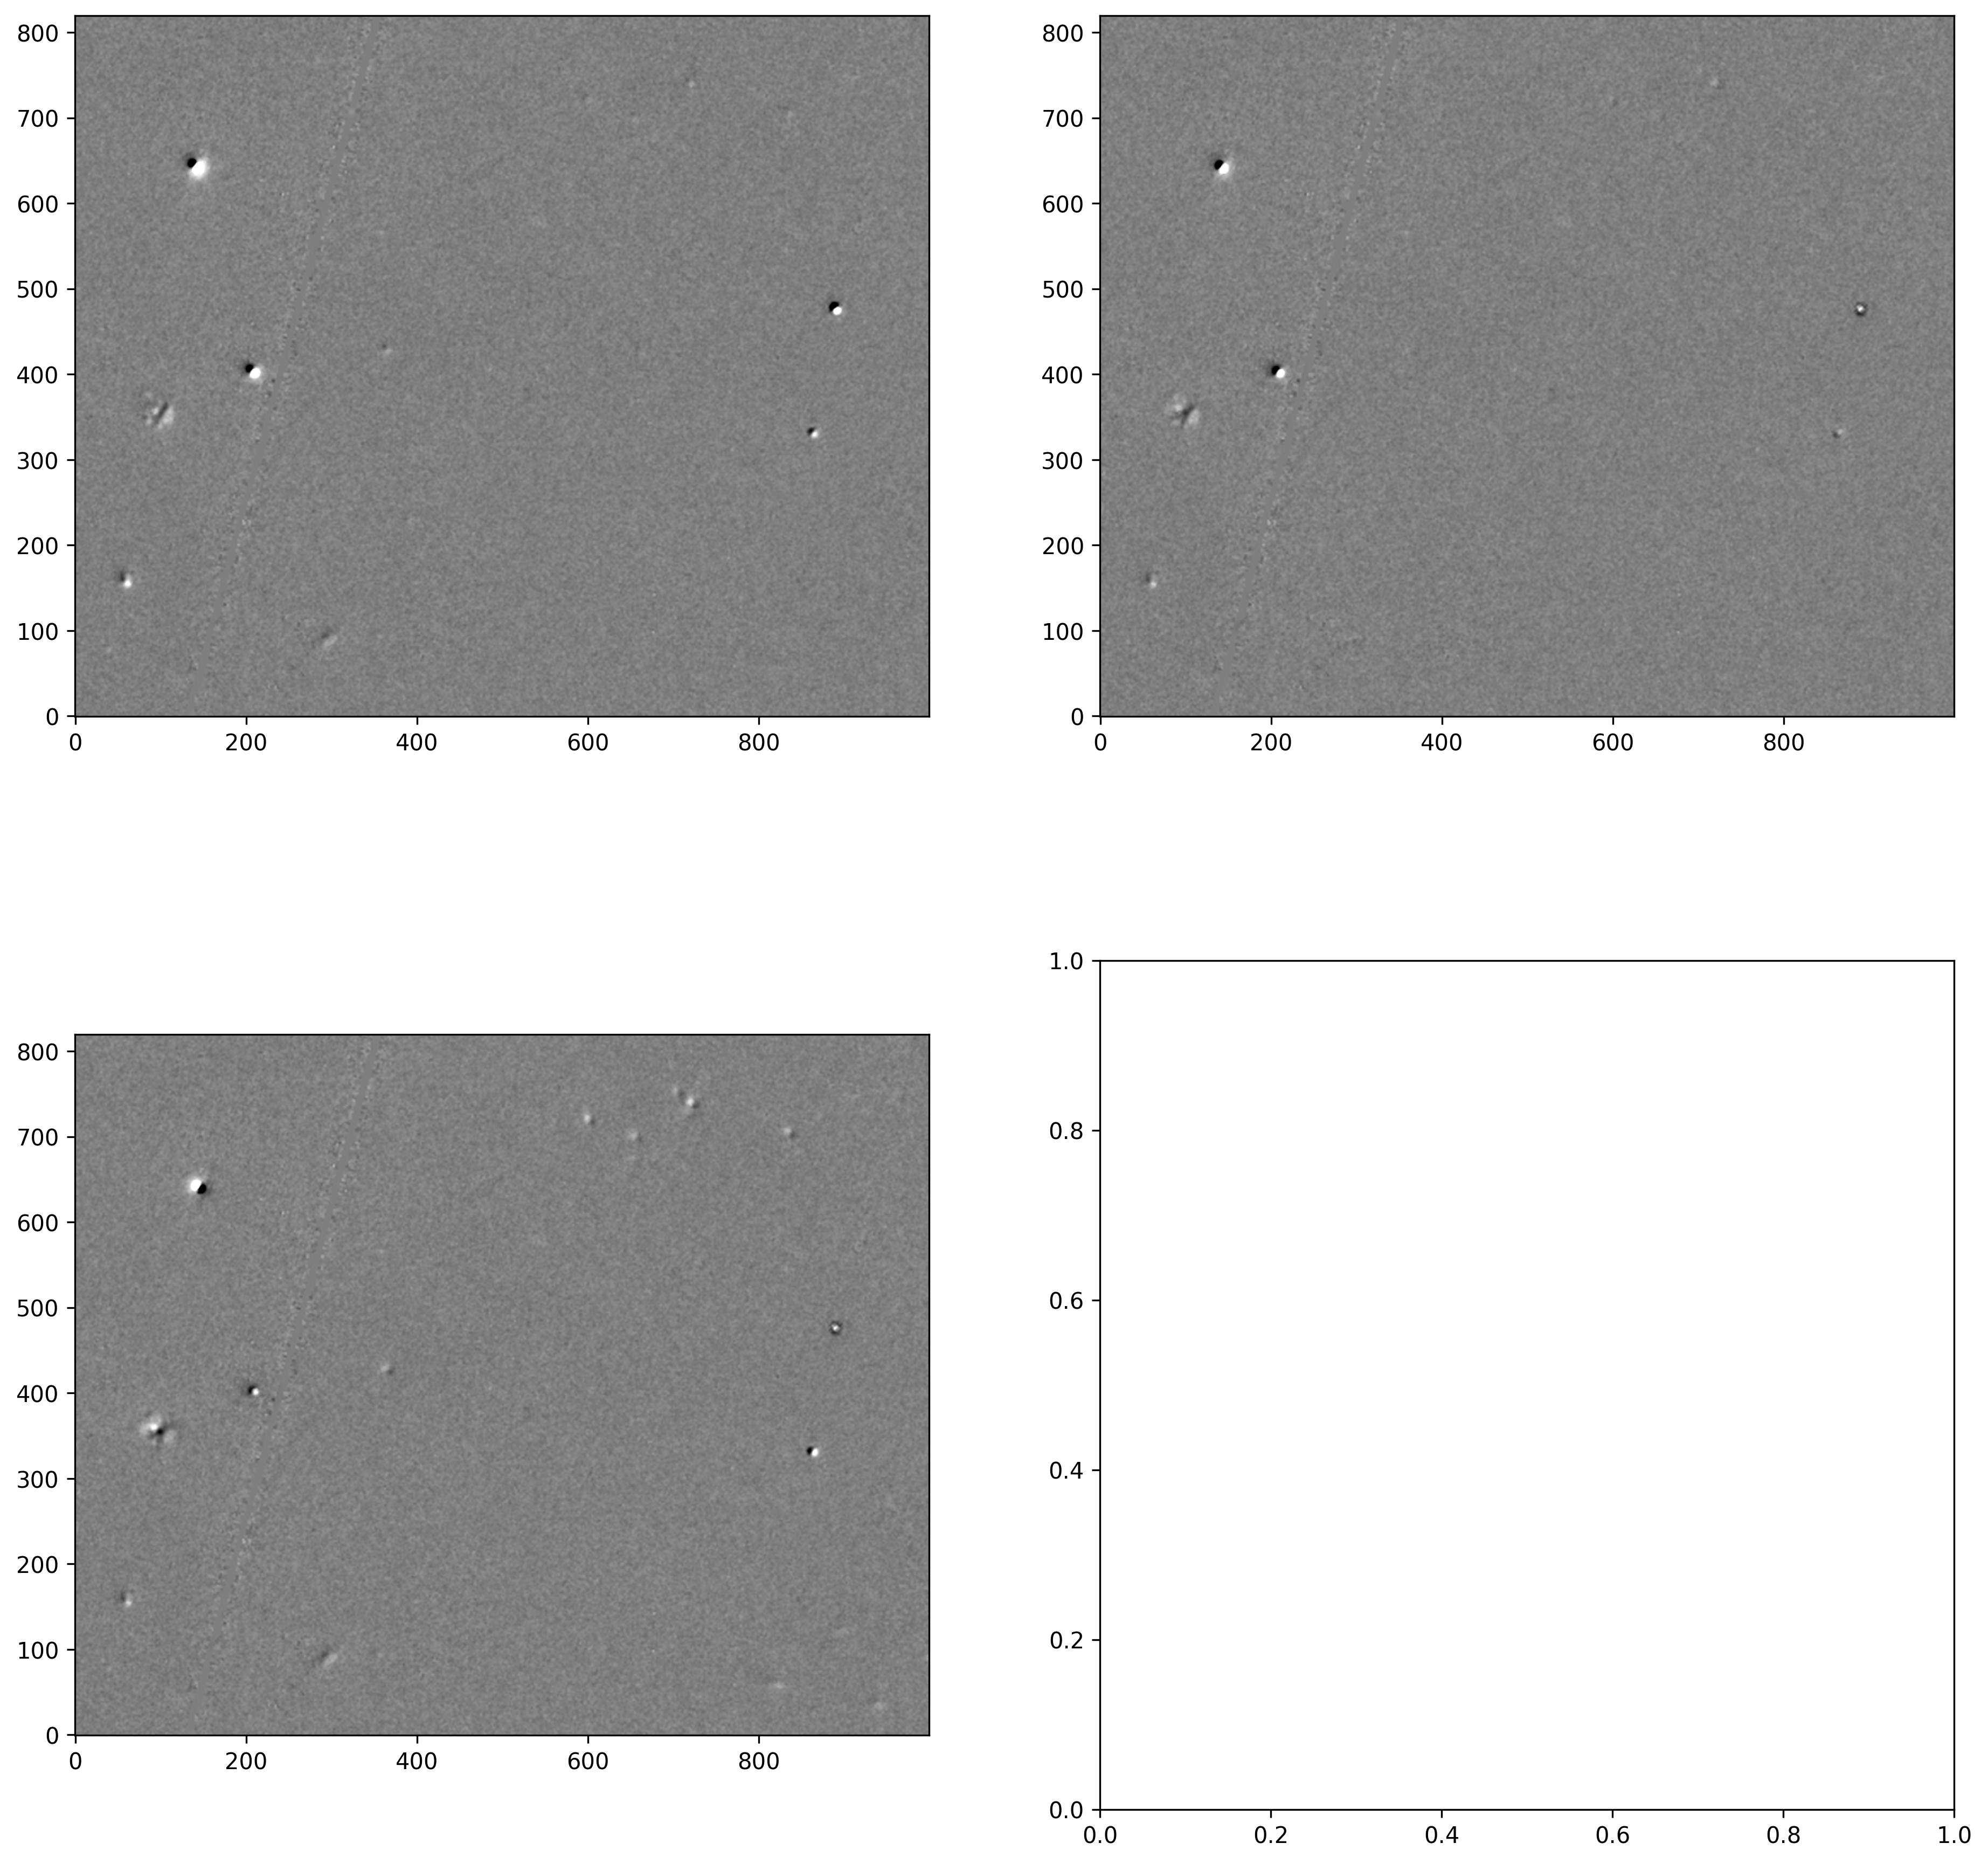

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(residual[i], origin='lower', cmap='gray', vmin=-5, vmax=5)


In [6]:
# errors ok
from astropy.stats import mad_std
import numpy as np
from astropy.nddata import block_reduce

# plt.imshow(cat770.wht, origin='lower')
# plt.imshow(cat770.sci, origin='lower', cmap='gray', vmin=-1,vmax=1)
sci770b3 = block_reduce(cat770.sci, (3,3), np.sum)/3
sci444b3 = block_reduce(cat444.sci, (3,3), np.sum)/3

print(mad_std(cat770.sci), np.mean(1/np.sqrt(cat770.ivar)), mad_std(sci770b3), mad_std(sci444b3))

# plt.imshow(cat444.wht, origin='lower')
# plt.imshow(cat444.sci, origin='lower', cmap='gray', vmin=-1,vmax=1)
print(mad_std(cat444.sci),np.mean(1/np.sqrt(cat444.ivar)))


0.23469904 0.7334598 0.5807125 0.027704054
0.016453132 0.032003887


In [10]:
# rms = np.random.randn(500,500)*2
# wht = np.ones_like(rms)*20


# from astropy. import block_reduce
# from mophongo.catalog import measure_ivar
# ivar  = measure_ivar(rms, wht=wht, background=0.0, nbin=3,ndilate=3)
# print(np.mean(np.sqrt(1/ivar)))


import numpy as np
np.sqrt(0)